In [ ]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fluidsynth is already the newest version (2.2.5-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
!pip install --upgrade pyfluidsynth

In [ ]:
!pip install pretty_midi

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#modules
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

In [ ]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

In [ ]:
#dataset
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

59243107/59243107 [==============================] - 1s 0us/step


In [ ]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


In [ ]:
sample_file = filenames[3]
print(sample_file)

data/maestro-v2.0.0/2018/MIDI-Unprocessed_Recital17-19_MID--AUDIO_19_R1_2018_wav--6.midi


In [ ]:
pm = pretty_midi.PrettyMIDI(sample_file)

In [ ]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
    waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
    # Take a sample of the generated waveform to mitigate kernel resets
    waveform_short = waveform[:seconds*_SAMPLING_RATE]
    return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [ ]:
display_audio(pm)

Inspection on the MIDI file. What kinds of instruments are used?



In [ ]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


In [ ]:
#extract notes
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=22, note_name=A#0, duration=0.0964
1: pitch=34, note_name=A#1, duration=0.1159
2: pitch=41, note_name=F2, duration=0.1185
3: pitch=46, note_name=A#2, duration=0.1836
4: pitch=50, note_name=D3, duration=0.1068
5: pitch=52, note_name=E3, duration=0.0378
6: pitch=53, note_name=F3, duration=0.1211
7: pitch=62, note_name=D4, duration=0.0977
8: pitch=58, note_name=A#3, duration=0.1263
9: pitch=55, note_name=G3, duration=0.1289


In [ ]:
#convert to note name
def midi_to_notes(midi_file: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)

    # Sort the notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - prev_start)
        notes['duration'].append(end - start)
        prev_start = start

    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [ ]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,22,0.955729,1.052083,0.000000,0.096354
1,34,0.962240,1.078125,0.006510,0.115885
2,41,1.299479,1.417969,0.337240,0.118490
3,46,1.423177,1.606771,0.123698,0.183594
4,50,1.531250,1.638021,0.108073,0.106771


In [ ]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['A#0', 'A#1', 'F2', 'A#2', 'D3', 'E3', 'F3', 'A#3', 'D4', 'G3'],
      dtype='<U3')

In [ ]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
    if count:
        title = f'First {count} notes'
    else:
        title = f'Whole track'
        count = len(notes['pitch'])
    plt.figure(figsize=(20, 4))
    plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
    plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
    plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
    plt.xlabel('Time [s]')
    plt.ylabel('Pitch')
    _ = plt.title(title)

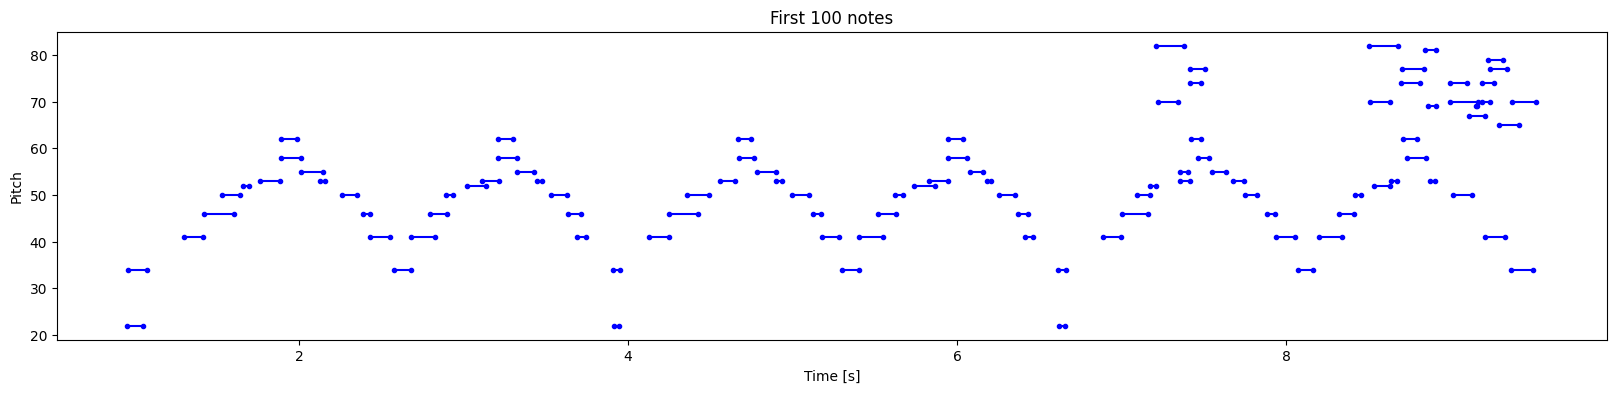

In [ ]:
plot_piano_roll(raw_notes, count=100)

Plot the notes for the entire track.



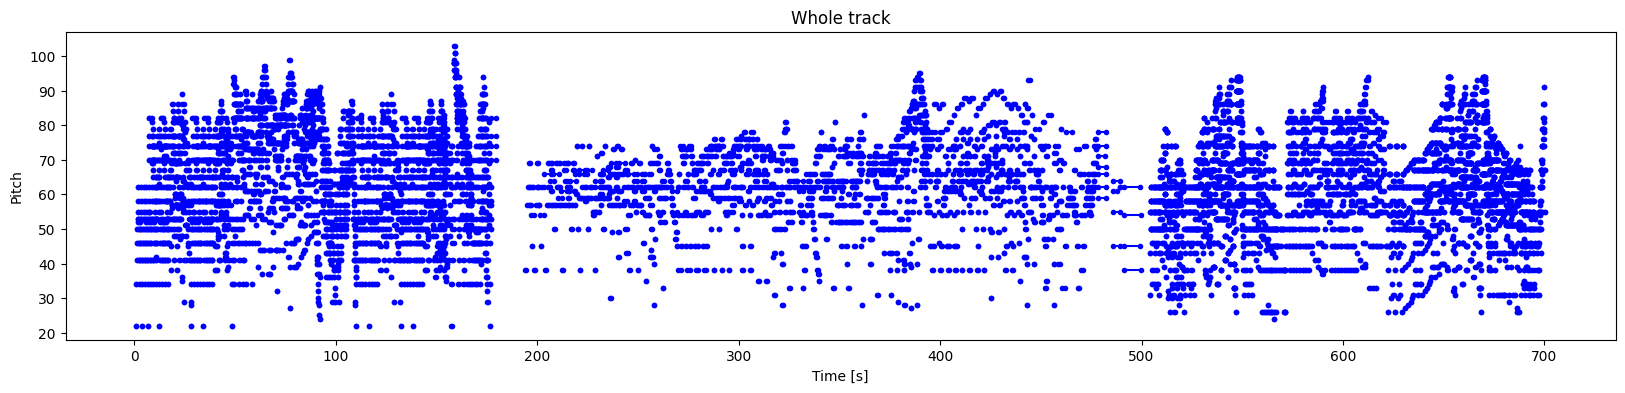

In [ ]:
plot_piano_roll(raw_notes)

In [ ]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

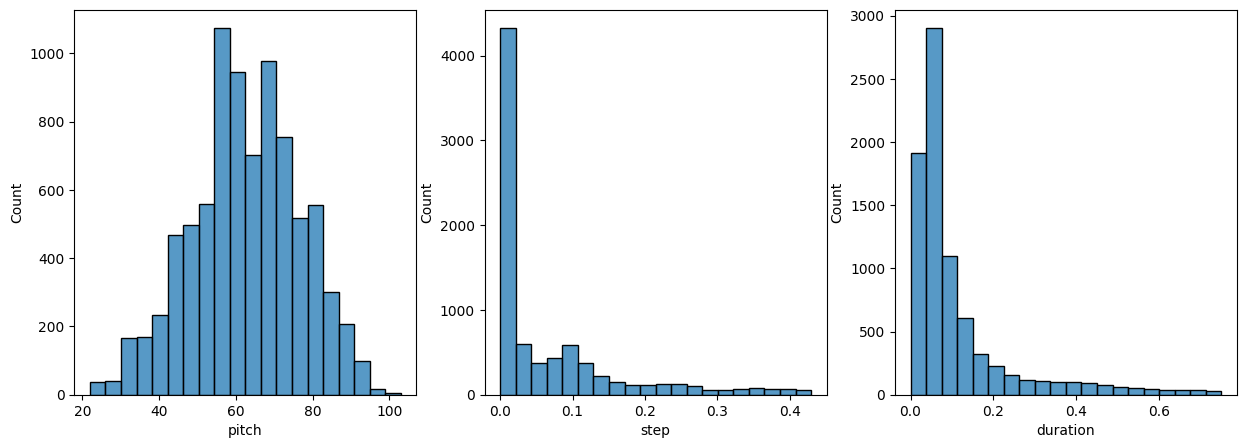

In [ ]:
plot_distributions(raw_notes)

In [ ]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=max(0, min(velocity, 127)),
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [ ]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [ ]:
#creating dataset
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [ ]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 42376


In [ ]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [ ]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [ ]:
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [ ]:
for seq, target in seq_ds.take(1):
    print('sequence shape:', seq.shape)
    print('sequence elements (first 10):', seq[0: 10])
    print()
    print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.671875   0.         0.37109375]
 [0.609375   0.         0.4296875 ]
 [0.390625   0.00390625 0.40364583]
 [0.578125   0.00260417 0.39192708]
 [0.296875   0.00130208 0.34895833]
 [0.6328125  0.         0.39322917]
 [0.390625   0.83463542 0.05208333]
 [0.484375   0.00130208 0.03255208]
 [0.328125   0.0078125  0.04036458]
 [0.4453125  0.01171875 0.03255208]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=57.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.006510416666666519>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.3958333333333335>}


In [ ]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

In [ ]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [ ]:
#build model
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 25, 3)]              0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 128)                  67584     ['input_1[0][0]']             
                                                                                                  
 duration (Dense)            (None, 1)                    129       ['lstm[0][0]']                
                                                                                                  
 pitch (Dense)               (None, 128)                  16512     ['lstm[0][0]']                
                                                                                              

Testing the model.evaluate function, you can see that the pitch loss is significantly greater than the step and duration losses. Note that loss is the total loss computed by summing all the other losses and is currently dominated by the pitch loss.

In [ ]:
losses = model.evaluate(train_ds, return_dict=True)
losses

661/661 [==============================] - 19s 17ms/step - loss: 5.3907 - duration_loss: 0.2505 - pitch_loss: 4.8467 - step_loss: 0.2936


{'loss': 5.3907246589660645,
 'duration_loss': 0.2504892349243164,
 'pitch_loss': 4.846653938293457,
 'step_loss': 0.293586790561676}

One way balance this is to use the loss_weights argument to compile:



In [ ]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [ ]:
model.evaluate(train_ds, return_dict=True)

661/661 [==============================] - 13s 17ms/step - loss: 0.7864 - duration_loss: 0.2505 - pitch_loss: 4.8467 - step_loss: 0.2936


{'loss': 0.7864084243774414,
 'duration_loss': 0.2504892349243164,
 'pitch_loss': 4.846653938293457,
 'step_loss': 0.293586790561676}

**Train the model.**



In [ ]:
import glob
import pickle
import numpy
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import BatchNormalization as BatchNorm
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}.keras'),
]

In [ ]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    batch_size=64,
)

Epoch 1/50
661/661 [==============================] - 30s 42ms/step - loss: 0.3435 - duration_loss: 0.0827 - pitch_loss: 3.9956 - step_loss: 0.0610
Epoch 2/50
661/661 [==============================] - 27s 41ms/step - loss: 0.3312 - duration_loss: 0.0783 - pitch_loss: 3.9017 - step_loss: 0.0578
Epoch 3/50
661/661 [==============================] - 30s 46ms/step - loss: 0.3254 - duration_loss: 0.0769 - pitch_loss: 3.8336 - step_loss: 0.0568
Epoch 4/50
661/661 [==============================] - 28s 42ms/step - loss: 0.3229 - duration_loss: 0.0762 - pitch_loss: 3.8009 - step_loss: 0.0566
Epoch 5/50
661/661 [==============================] - 28s 42ms/step - loss: 0.3184 - duration_loss: 0.0736 - pitch_loss: 3.7906 - step_loss: 0.0553
Epoch 6/50
661/661 [==============================] - 29s 45ms/step - loss: 0.3172 - duration_loss: 0.0728 - pitch_loss: 3.7833 - step_loss: 0.0553
Epoch 7/50
661/661 [==============================] - 28s 42ms/step - loss: 0.3161 - duration_loss: 0.0715 - pit

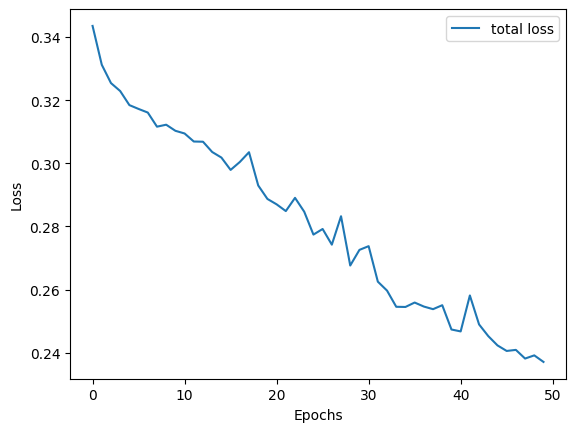

In [ ]:
import matplotlib.pyplot as plt

# Plotting the loss
plt.plot(history.epoch, history.history['loss'], label='total loss')

# Adding labels to the x-axis and y-axis
plt.xlabel('Epochs')  # Label for the x-axis
plt.ylabel('Loss')    # Label for the y-axis

# Display the plot
plt.legend()  # Show the legend if you have multiple lines
plt.show()

In [ ]:
def predict_next_note(
    notes: np.ndarray,
    keras_model: tf.keras.Model,
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [ ]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 31ms/step


In [ ]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,55,0.037994,0.120729,0.037994,0.158723
1,102,0.312979,0.000000,0.350973,0.350973
2,102,0.340644,0.000000,0.691616,0.691616
3,69,0.342822,0.000000,1.034438,1.034438
4,99,0.345368,0.000000,1.379806,1.379806
5,73,0.342097,0.000000,1.721904,1.721904
6,47,0.345753,0.000000,2.067657,2.067657
7,95,0.354698,0.000000,2.422355,2.422355
8,40,0.344057,0.000000,2.766412,2.766412
9,94,0.349634,0.000000,3.116046,3.116046


In [ ]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

In [ ]:
# !pip install google.colab

In [ ]:
# from google.colab import files
# files.download(out_file)

Visualize the generated notes.



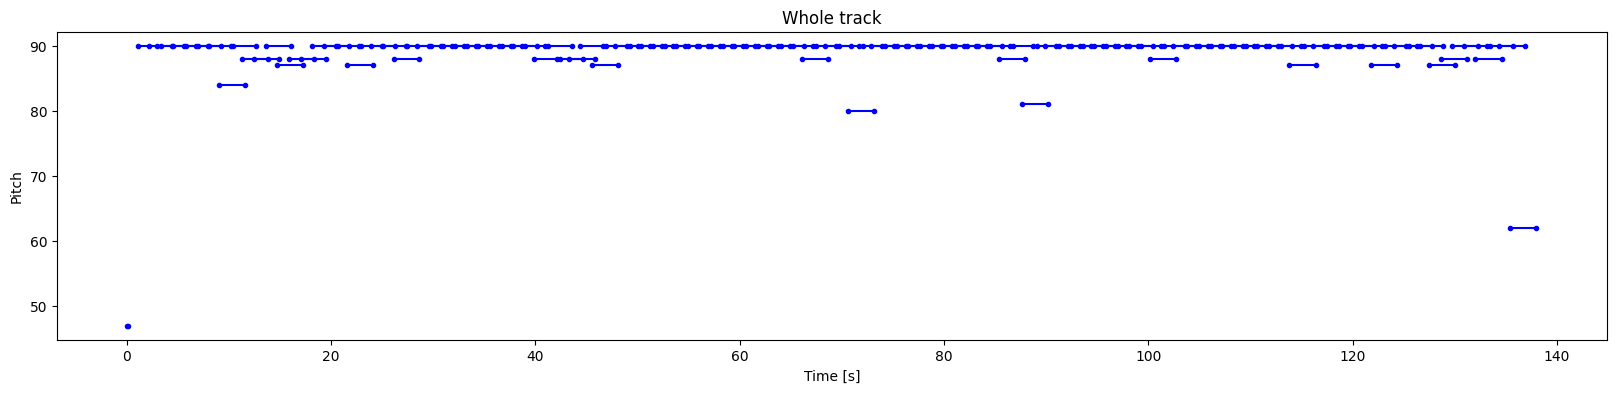

In [ ]:
plot_piano_roll(generated_notes)

Check the distributions of pitch, step and duration.



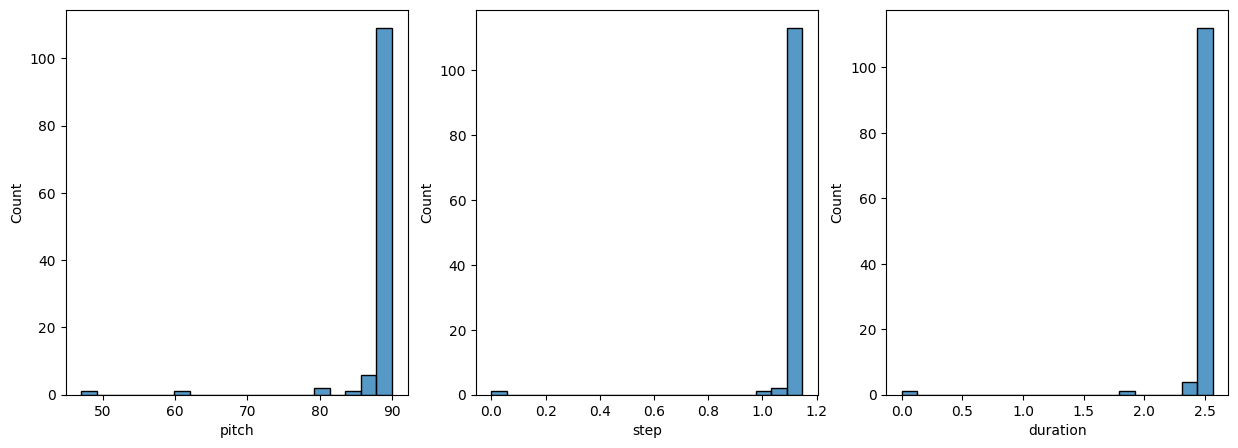

In [ ]:
plot_distributions(generated_notes)

# Variations - LSTM - 512 Layers


In [ ]:
input_shape = (seq_length, 3)
learning_rate = 0.001

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(512)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(512, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 25, 3)]              0         []                            
                                                                                                  
 lstm_1 (LSTM)               (None, 512)                  1056768   ['input_2[0][0]']             
                                                                                                  
 duration (Dense)            (None, 1)                    513       ['lstm_1[0][0]']              
                                                                                                  
 pitch (Dense)               (None, 512)                  262656    ['lstm_1[0][0]']              
                                                                                            

In [ ]:
losses = model.evaluate(train_ds, return_dict=True)
losses

683/683 [==============================] - 4s 4ms/step - loss: 6.5758 - duration_loss: 0.2272 - pitch_loss: 6.2404 - step_loss: 0.1082


{'loss': 6.575801372528076,
 'duration_loss': 0.22717559337615967,
 'pitch_loss': 6.240383625030518,
 'step_loss': 0.1082412451505661}

In [ ]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.08,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [ ]:
model.evaluate(train_ds, return_dict=True)

683/683 [==============================] - 3s 4ms/step - loss: 0.8346 - duration_loss: 0.2272 - pitch_loss: 6.2404 - step_loss: 0.1082


{'loss': 0.8346477150917053,
 'duration_loss': 0.22717559337615967,
 'pitch_loss': 6.240383625030518,
 'step_loss': 0.1082412451505661}

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints2/ckpt_{epoch}.keras'),
]

In [ ]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    batch_size=32,
)

Epoch 1/50
683/683 [==============================] - 8s 7ms/step - loss: 0.6925 - duration_loss: 0.1632 - pitch_loss: 5.3511 - step_loss: 0.1012
Epoch 2/50
683/683 [==============================] - 5s 7ms/step - loss: 0.5834 - duration_loss: 0.1572 - pitch_loss: 4.1573 - step_loss: 0.0937
Epoch 3/50
683/683 [==============================] - 5s 8ms/step - loss: 0.5691 - duration_loss: 0.1506 - pitch_loss: 4.0963 - step_loss: 0.0907
Epoch 4/50
683/683 [==============================] - 5s 7ms/step - loss: 0.5643 - duration_loss: 0.1482 - pitch_loss: 4.0772 - step_loss: 0.0899
Epoch 5/50
683/683 [==============================] - 5s 7ms/step - loss: 0.5613 - duration_loss: 0.1464 - pitch_loss: 4.0688 - step_loss: 0.0895
Epoch 6/50
683/683 [==============================] - 5s 7ms/step - loss: 0.5587 - duration_loss: 0.1445 - pitch_loss: 4.0635 - step_loss: 0.0891
Epoch 7/50
683/683 [==============================] - 5s 7ms/step - loss: 0.5572 - duration_loss: 0.1434 - pitch_loss: 4.061

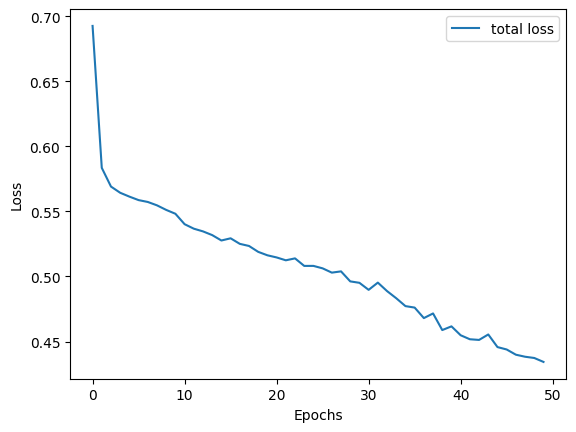

In [ ]:
import matplotlib.pyplot as plt

# Plotting the loss
plt.plot(history.epoch, history.history['loss'], label='total loss')

# Adding labels to the x-axis and y-axis
plt.xlabel('Epochs')  # Label for the x-axis
plt.ylabel('Loss')    # Label for the y-axis

# Display the plot
plt.legend()  # Show the legend if you have multiple lines
plt.show()

In [ ]:
temperature = 4.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 27ms/step


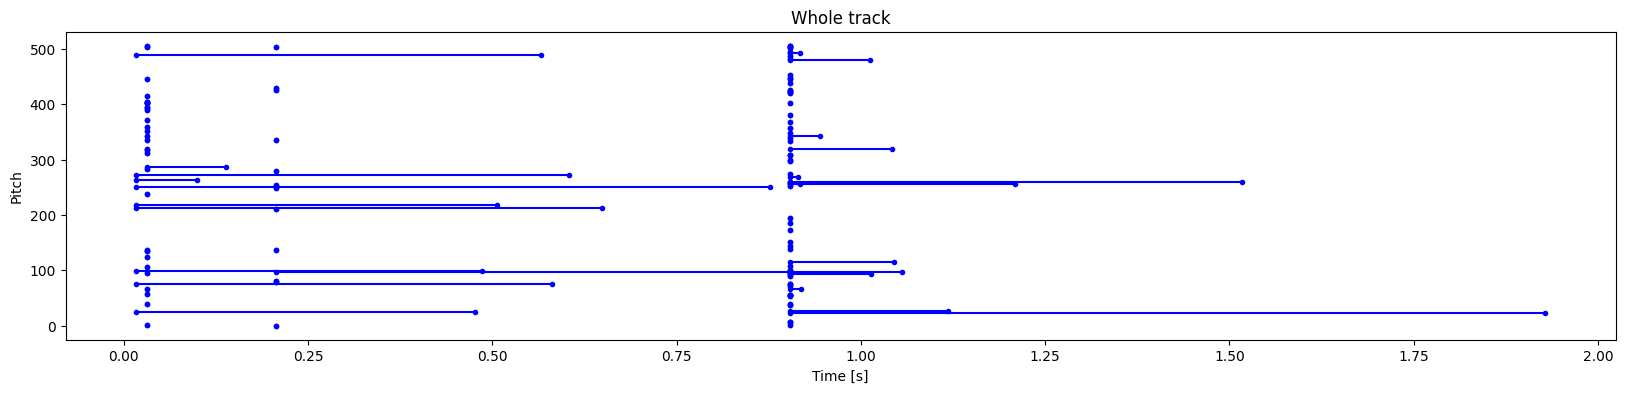

In [ ]:
plot_piano_roll(generated_notes)

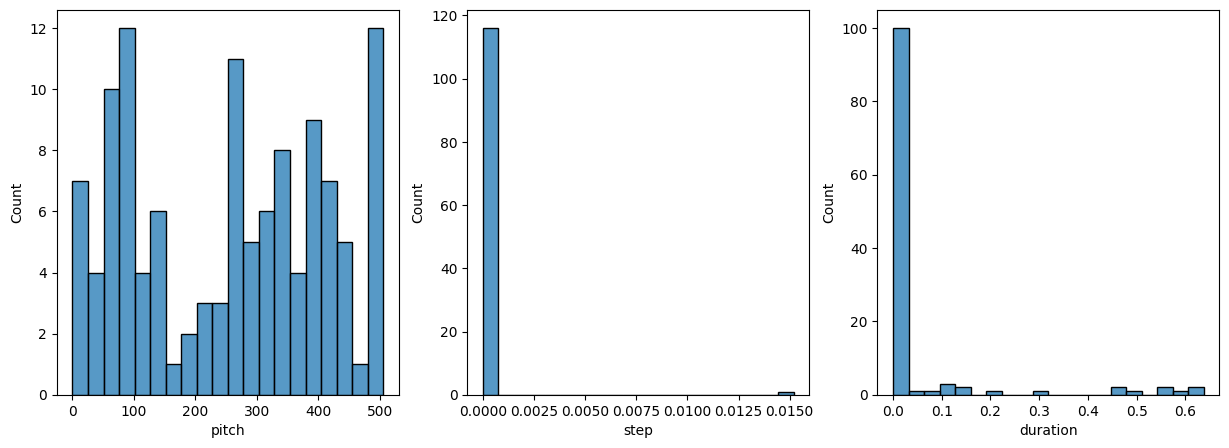

In [ ]:
plot_distributions(generated_notes)

In [ ]:
out_file = './output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)

# VARIATIONAL AUTOENCODER

In [ ]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

In [ ]:
sample_file = filenames[5]
print(sample_file)

data/maestro-v2.0.0/2014/MIDI-UNPROCESSED_04-07-08-10-12-15-17_R2_2014_MID--AUDIO_17_R2_2014_wav.midi


In [ ]:
pm = pretty_midi.PrettyMIDI(sample_file)

In [ ]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import pretty_midi
import pandas as pd
import collections
import glob
import pathlib

# Define constants
SEQUENCE_LENGTH = 100  # Length of input sequences
NOTE_DIM = 128  # Dimensionality of the input (one-hot encoded MIDI notes)
LATENT_DIM = 64  # Dimensionality of the latent space
BATCH_SIZE = 32

# Function to convert MIDI files to DataFrame of notes
def midi_to_notes(midi_file: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)

    # Sort the notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - prev_start)
        notes['duration'].append(end - start)
        prev_start = start

    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

# Function to preprocess MIDI data
def preprocess_midi_data(midi_files):
    if not midi_files:
        raise ValueError("No MIDI files found in the specified directory.")

    all_notes = pd.concat([midi_to_notes(file) for file in midi_files], ignore_index=True)
    return all_notes

# Custom data generator for MIDI sequences
class MIDIDataGenerator(keras.utils.Sequence):
    def __init__(self, notes_df, batch_size):
        self.notes_df = notes_df
        self.batch_size = batch_size
        self.num_batches = len(notes_df) // batch_size

    def __len__(self):
        return self.num_batches

    def __getitem__(self, idx):
        batch_df = self.notes_df[idx * self.batch_size: (idx + 1) * self.batch_size]
        batch_sequences = np.zeros((self.batch_size, SEQUENCE_LENGTH, NOTE_DIM), dtype=np.float32)

        for i, row in enumerate(batch_df.itertuples()):
            start_idx = max(0, int(row.start))
            end_idx = min(SEQUENCE_LENGTH, int(row.end))

            for j in range(start_idx, end_idx):
                pitch = int(row.pitch)
                if 0 <= pitch < NOTE_DIM:
                    batch_sequences[i, j, pitch] = 1.0

        return batch_sequences, batch_sequences  # Autoencoder, reconstruction target is the input itself

# Build the VAE model
def build_vae():
    # Encoder
    encoder_inputs = keras.Input(shape=(SEQUENCE_LENGTH, NOTE_DIM))
    x = layers.Flatten()(encoder_inputs)
    x = layers.Dense(512, activation='relu')(x)
    z_mean = layers.Dense(LATENT_DIM)(x)
    z_log_var = layers.Dense(LATENT_DIM)(x)

    # Reparameterization trick
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], LATENT_DIM), mean=0., stddev=1.)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling)([z_mean, z_log_var])

    # Decoder
    decoder_inputs = layers.Input(shape=(LATENT_DIM,))
    x = layers.Dense(512, activation='relu')(decoder_inputs)
    x = layers.Dense(SEQUENCE_LENGTH * NOTE_DIM, activation='sigmoid')(x)
    decoder_outputs = layers.Reshape((SEQUENCE_LENGTH, NOTE_DIM))(x)

    # Define models
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
    decoder = keras.Model(decoder_inputs, decoder_outputs, name='decoder')
    vae_outputs = decoder(encoder(encoder_inputs)[2])
    vae = keras.Model(encoder_inputs, vae_outputs, name='vae')

    # Define loss function
    reconstruction_loss = tf.keras.losses.binary_crossentropy(encoder_inputs, vae_outputs)
    reconstruction_loss *= SEQUENCE_LENGTH * NOTE_DIM
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = tf.reduce_mean(kl_loss)
    kl_loss *= -0.5
    vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)

    return vae

# Get the list of MIDI files
midi_files = glob.glob(str(data_dir / '**/*.mid*'), recursive=True)[:600]  # Limit to 600 files

# Preprocess MIDI data
all_notes = preprocess_midi_data(midi_files)

# Create custom data generator
train_data_generator = MIDIDataGenerator(all_notes, batch_size=BATCH_SIZE)

# Build and compile the VAE model
vae = build_vae()
vae.compile(optimizer='adam')

# Configure model checkpoint to save the model weights after every epoch
model_checkpoint = keras.callbacks.ModelCheckpoint('vae_model_checkpoint.h5', save_best_only=True)

# Train the model using the custom data generator
history = vae.fit(train_data_generator, epochs=3, steps_per_epoch=len(train_data_generator), callbacks=[model_checkpoint])

# Save the trained model
vae.save('vae_model.h5')

# Save the encoder and decoder models
encoder = vae.get_layer('encoder')
decoder = vae.get_layer('decoder')
encoder.save('encoder_model.h5')
decoder.save('decoder_model.h5')


Epoch 1/3
110761/110764 [============================>.] - ETA: 0s - loss: 1.3342

110764/110764 [==============================] - 983s 9ms/step - loss: 1.3342
Epoch 2/3
110759/110764 [============================>.] - ETA: 0s - loss: 0.3711

110764/110764 [==============================] - 1003s 9ms/step - loss: 0.3711
Epoch 3/3
110758/110764 [============================>.] - ETA: 0s - loss: 0.4763

110764/110764 [==============================] - 984s 9ms/step - loss: 0.4765


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
!pip install midi2audio

In [ ]:
!pip install pretty_midi

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pretty_midi
from midi2audio import FluidSynth
from IPython.display import Audio

# Load the trained VAE model
#vae = tf.keras.models.load_model('vae_model (1).h5')
#vae.compile(optimizer='adam', loss='binary_crossentropy')

LATENT_DIM = 64  # Define the latent dimension size


# Load the encoder and decoder models
encoder = tf.keras.models.load_model('encoder_model.h5')
decoder = tf.keras.models.load_model('decoder_model.h5')

# Function to generate content using VAE model
def generate_content(num_samples=1):
    latent_vectors = np.random.normal(size=(num_samples, LATENT_DIM))
    generated_sequences = decoder.predict(latent_vectors)
    return generated_sequences

# Generate new content
num_samples = 5  # Number of samples to generate
generated_content = generate_content(num_samples=num_samples)

# Process generated content and save as MIDI files
for i, sequence in enumerate(generated_content):
    # Create a PrettyMIDI object
    midi_data = pretty_midi.PrettyMIDI()

    # Create an Instrument instance
    instrument_program = pretty_midi.instrument_name_to_program('Acoustic Grand Piano')
    instrument = pretty_midi.Instrument(program=instrument_program)

    # Convert the generated sequence to MIDI notes
    for step in sequence:
        notes = np.where(step > 0)[0]
        for note in notes:
            note_name = pretty_midi.note_number_to_name(note)
            start_time = len(instrument.notes) * 0.5  # Adjust timing
            end_time = start_time + 0.5  # Adjust duration
            midi_note = pretty_midi.Note(velocity=100, pitch=note, start=start_time, end=end_time)
            instrument.notes.append(midi_note)

    # Add the instrument to the MIDI data
    midi_data.instruments.append(instrument)

    # Write the MIDI data to a file
    midi_filename = f'generated_content_{i}.mid'
    midi_data.write(midi_filename)

1/1 [==============================] - 0s 91ms/step


In [ ]:
import pretty_midi
pm = pretty_midi.PrettyMIDI("generated_content_2.mid")

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pretty_midi
from midi2audio import FluidSynth
from IPython.display import Audio

In [ ]:
LATENT_DIM = 64  # Define the latent dimension size
encoder = tf.keras.models.load_model('encoder_model.h5')
decoder = tf.keras.models.load_model('decoder_model.h5')

# Function to generate content using VAE model
def generate_content(num_samples=1):
    latent_vectors = np.random.normal(size=(num_samples, LATENT_DIM))
    generated_sequences = decoder.predict(latent_vectors)
    return generated_sequences

# Generate new content
num_samples = 5  # Number of samples to generate
generated_content = generate_content(num_samples=num_samples)

# Process generated content and save as MIDI files
for i, sequence in enumerate(generated_content):
    # Create a PrettyMIDI object
    midi_data = pretty_midi.PrettyMIDI()

    # Create an Instrument instance
    instrument_program = pretty_midi.instrument_name_to_program('Acoustic Grand Piano')
    instrument = pretty_midi.Instrument(program=instrument_program)

    # Convert the generated sequence to MIDI notes
    for step in sequence:
        notes = np.where(step > 0)[0]
        for note in notes:
            note_name = pretty_midi.note_number_to_name(note)
            start_time = len(instrument.notes) * 0.5  # Adjust timing
            end_time = start_time + 0.5  # Adjust duration
            midi_note = pretty_midi.Note(velocity=80 + np.random.randint(-10, 10), pitch=note, start=start_time, end=end_time)
            instrument.notes.append(midi_note)

    # Add the instrument to the MIDI data
    midi_data.instruments.append(instrument)

    # Write the MIDI data to a file
    midi_filename = f'generated_content_{i}.mid'
    midi_data.write(midi_filename)

1/1 [==============================] - 0s 50ms/step
